In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL

In questa lezione, vedremo alcune tecniche per decomporre e modellare le serie temporali.

## Lettura dei dati

In primis, leggiamo i dati a partire dal file `co2.csv`. Fatto questo, plottiamo i dati.

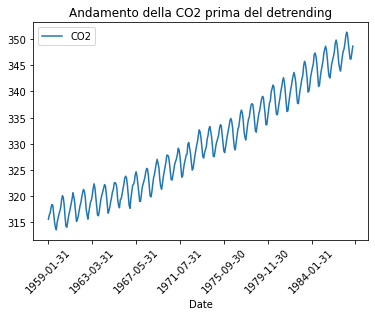

In [2]:
co2 = pd.read_csv('../dataset/co2.csv', index_col='Date')
co2.plot(
    title='Andamento della CO2 prima del detrending', rot=45)
plt.show()

Nei dati è presente un trend molto evidente. Di conseguenza, potremo rimuoverlo effettuando l'operazione di detrending, o differencing. In tal senso, possiamo usare la funzione [`diff()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html) di Pandas.

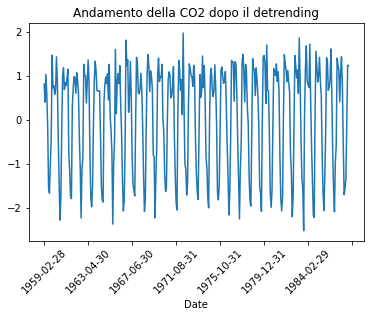

In [3]:
co2['CO2'].diff().dropna(axis=0).plot(
    title='Andamento della CO2 dopo il detrending', rot=45)
plt.show()

## Decomposizione STL

A questo punto, possiamo usare il metodo `STL` del package `statsmodels.tsa.seasonal` per effettuare la decomposizione STL della serie temporale sotto analisi. In particolare, supporremo un ciclo di 24 mesi, ed una stagionalità annuale.

Ricordiamo che la differenza tra pattern ciclici e stagionali sta nel fatto che, mentre i secondi hanno lunghezza ben definita, i primi sono generalmente di lunghezza variabile e conosciuta solo approssimativamente a priori. Per rimanere al nostro esempio, il ciclo potrebbe essere legato ad un ciclo macroeconomico, ad esempio.

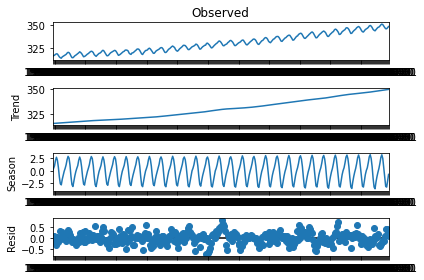

In [4]:
stl = STL(co2, period=24, seasonal=13)
res = stl.fit()
fig = res.plot()

## Modellazione con ARIMA

Una volta completata la decomposizione STL, possiamo provare a creare un modello della nostra serie temporale usando un ARIMA.

Ovviamente, dato che abbiamo supposto esserci una componente stagionale, dovremo in qualche modo tenerne conto; lo faremo nel seguito.

Per adesso, però, limitiamoci a creare un modello ARIMA di ordine (1, 0, 0), ricordandoci di passare al costruttore un array NumPy (e non un dataframe).

In [5]:
model = ARIMA(co2.to_numpy(), order=(1, 0, 0))

Fittiamo il modello, ed usiamo la funzione `summary()` per visualizzare alcune metriche descrittive.

In [6]:
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  348
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -550.426
Date:                Sat, 17 Jul 2021   AIC                           1106.853
Time:                        10:35:24   BIC                           1118.409
Sample:                             0   HQIC                          1111.454
                                - 348                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        331.3255      9.910     33.434      0.000     311.903     350.748
ar.L1          0.9961      0.006    160.413      0.000       0.984       1.008
sigma2         1.3656      0.169      8.076      0.0

Particolarmente interessanti sono i valori di `AIC`, `BIC` ed `HQIC`, stanti rispettivamente per *Akaike Information Criterion*, *Bayesian Information Criterion* ed *Hannan-Quinn Information Criterion*. Trovate una descrizione più completa [a questo link](https://www.lorenzogovoni.com/selezione-del-modello-aic-bic-hqic/); tuttavia, basta sapere che, tra due modelli, si sceglie quello con i valori di AIC, BIC ed HQIC inferiori.

## Predizioni

### Predizioni single-step

Vediamo ora come effettuare delle predizioni usando il modello fittato. In primis, possiamo usare la funzione `forecast`, che ci permette di effettaure una predizione *single-step out-of-sample*, ovvero dell'istante temporale immediatamente successivo al termine della serie temporale.

In [7]:
y_pred = fitted.forecast()[0]
print('Predizione single-step out-of-sample: {}'.format(round(y_pred, 3)))

Predizione single-step out-of-sample: 348.602


Abbiamo poi la funzione `predict`, che ci mostra i valori stimati dal modello all'interno di un certo intervallo. Ad esempio:

In [8]:
predictions = fitted.predict(start=328, end=348)

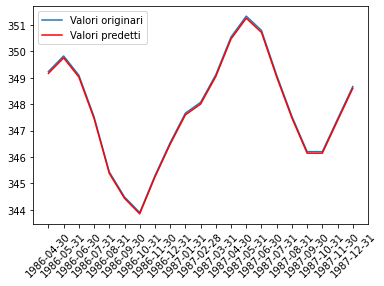

In [9]:
fig, ax = plt.subplots()

temp_dset = co2.reset_index()
xlabels = temp_dset.loc[327:, 'Date']
ax.plot(temp_dset.loc[327:, 'Date'], temp_dset.loc[327:, 'CO2'], label='Valori originari')
ax.plot(temp_dset.loc[327:, 'Date'], predictions, color='red', label='Valori predetti')
ax.set_xticklabels(xlabels, rotation=45)
ax.legend()
plt.show()

### Predizioni multi-step

Queste funzioni possono anche essere usate per effettuare la predizione *multi-step*, specificando il numero di step successivi su cui vogliamo fare la predizione. Ad esempio:

In [10]:
y_pred_ms = fitted.forecast(steps=12)[0]
print('Predizione multi-step con step 12: {}'.format(round(y_pred_ms, 3)))

Predizione multi-step con step 12: 348.602


In [11]:
predictions_ms = fitted.predict(start=330, end=350)

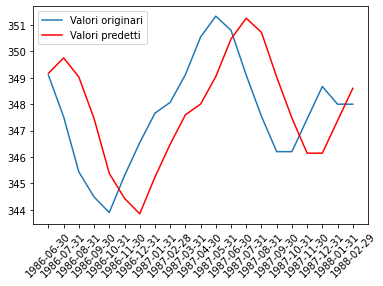

In [12]:
fig, ax = plt.subplots()
temp_dset = co2.reset_index()
xlabels = temp_dset.loc[329:, 'Date'].to_numpy()
xlabels = np.append(xlabels, ['1988-01-31', '1988-02-29'])
values = temp_dset.loc[329:, 'CO2'].to_numpy()
values = np.append(values, [348, 348])
ax.plot(xlabels, values, label='Valori originari')
ax.plot(xlabels, predictions, color='red', label='Valori predetti')
ax.set_xticklabels(xlabels, rotation=45)
ax.legend()
plt.show()

Anche in questo caso, è evidente come si abbia a che fare con risultati subottimi. Nelle prossime lezioni, proveremo a porvi rimedio, usando tecniche ed approcci più sofisticati.